Data Science Final Report - UBC Minecraft Server Exploratory Question


Miles Young
University of British Columbia
DSCI-100 003
Melissa Lee
23/06/2025

Intro

A research group in computer science has created a Minecraft server and gathered data as to gamers prior experience with the game, whether they are subscribed to a gaming newsletter, their hours played on the server and their age. The question this report will attempt to answer is: Can age and hours played on the Minecraft server predict if an individual is subscribed to a gaming newsletter? All the while looking out for a trend of whether ones experience with Minecraft may coincide with their age, influence how much time they spent on the server or if they are subscribed to a newsletter.
    
The data provided by the research group consists of two tables named "players.csv" and "sessions.csv". For the purposes of this report all the necessary can be found in players.csv, therefore we will not load in sessions.csv. Players.csv has 196 observations and 7 columns. The experience column describes an individuals prior experience with Minecraft with a single word, including "Beginner", "Amateur", "Regular", "Pro", and "Veteran". The subscribe column, uses the logical dennotation of "TRUE" or "FALSE" to communicate whether the person has subscribed to a gaming newsletter. The hashedEmail is an encoded version of the individuals email and is not relevant for this report. The played_hours column lists the hours that any person played on the server. The name, gender and age columns are self explanatory but we will only be using the age column. There are two people whose age is not listed so we must remove them from the table leading to 194 observations being used as data.

Methods & Results

First we load the necessary libraries and read in the players.csv data.

In [ ]:
library(tidyverse)
library(tidymodels)
library(repr)
library(infer)
options(repr.matrix.max.rows = 6)

download.file("https://raw.githubusercontent.com/mileshyoung/dsci-100_final_report/refs/heads/main/data/players.csv", "data/players.csv")
players <- read_csv("data/players.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


Then we clean up the data by making all the column names lowercase, changing our eventual classification column into a factor, only selecting the relevant columns to answer our question and removing all NA from the table. Now we have age which will be our x axis, played_hours as our y axis and subscribe as the class.

In [24]:
player <- players |>
    mutate(age = Age) |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(subscribe, played_hours, age) |>
    na.omit()
player

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


After the data is clean we can start performing cross validation to determine the best value for k. Afterwards we will calculate the accuracy, recall and display the confusion matrix for the k-value we choose. We do this by spliting the data into training and testing with a 75:25 split. Then we perform 8 folds such that each fold has around 12-20 observations. With around 20 observations per fold just to be safe we can look at all the k-values from 1 to 12. Once everything is plugged into the workflow we calculate the accuracy for each of the k-values, graph them for better visual clarity and then display the exact values for the top 3. The accuracies are very similar so I choose to run the testing split on k = 5 and k = 8.

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6179529,8,0.04445487,Preprocessor1_Model01
1,roc_auc,binary,0.5014297,8,0.04426142,Preprocessor1_Model01
2,accuracy,binary,0.6540127,8,0.05120134,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,roc_auc,binary,0.5392205,8,0.05532527,Preprocessor1_Model11
12,accuracy,binary,0.7426993,8,0.01887664,Preprocessor1_Model12
12,roc_auc,binary,0.5653060,8,0.05833512,Preprocessor1_Model12


neighbors,mean
<int>,<dbl>
5,0.7518659
8,0.7477174
7,0.7427174


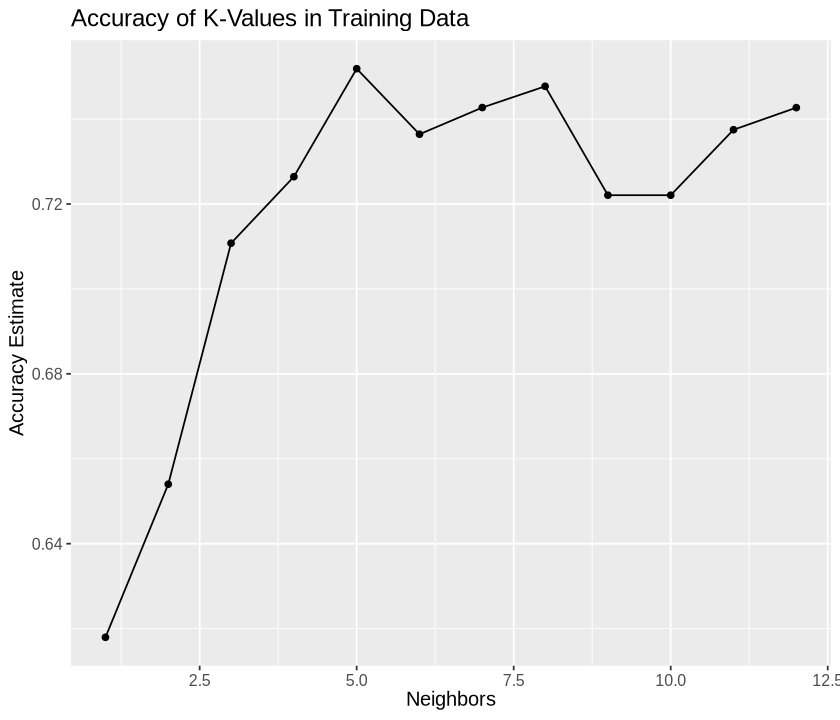

In [134]:
set.seed(42)
player_split <- initial_split(player, prop = 0.75, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

player_vfold <- vfold_cv(player, v = 8, strata = subscribe)
k_vals <- tibble(neighbors = 1:12)

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")
player_recipe <- recipe(subscribe ~., data = player_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    tune_grid(resamples = player_vfold, grid = k_vals) |>
    collect_metrics()
player_fit
accuracy_results <- player_fit |>
    filter(.metric == "accuracy")

options(repr.plot.width = 7, repr.plot.height = 6)
accuracy_result_plot <- accuracy_results |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    ggtitle("Accuracy of K-Values in Training Data") +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))
accuracy_result_plot

best_k <- accuracy_results |>
    select(neighbors, mean) |>
    arrange(desc(mean)) |>
    slice(1,2,3)
best_k

Producing the accuracy, recall and confusion matrix for k = 5 and k = 8 we see that the accuracy is significantly lower than expected when predicting the testing split for k = 5. However with more than half predictions being correct the evidence suggests there is potentially an identifiable relationship between age, hours played on the server and being subscribed to a newsletter.

In [120]:
k5_player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")
k5_player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(k5_player_spec) |>
    fit(data = player_training)
player5_predictions <- predict(k5_player_fit, player_testing) |>
    bind_cols(player_testing)
player5_prediction_accuracy <- player5_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
player5_prediction_recall <- player5_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")
player5_conf_matrix <- player5_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
player5_prediction_accuracy
player5_prediction_recall
player5_conf_matrix

k8_player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
    set_engine("kknn") |>
    set_mode("classification")
k8_player_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(k8_player_spec) |>
    fit(data = player_training)
player8_predictions <- predict(k8_player_fit, player_testing) |>
    bind_cols(player_testing)
player8_prediction_accuracy <- player8_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")
player8_prediction_recall <- player8_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")
player8_conf_matrix <- player8_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
player8_prediction_accuracy
player8_prediction_recall
player8_conf_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5918367


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.6153846


          Truth
Prediction FALSE TRUE
     FALSE     8   15
     TRUE      5   21

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.5384615


          Truth
Prediction FALSE TRUE
     FALSE     7    7
     TRUE      6   29

In [ ]:
This is further supported when we examine the graph.

Warning message in scale_y_continuous(trans = "log2", breaks = c(0.25, 0.5, 1, 2, :
“log-2 transformation introduced infinite values.”


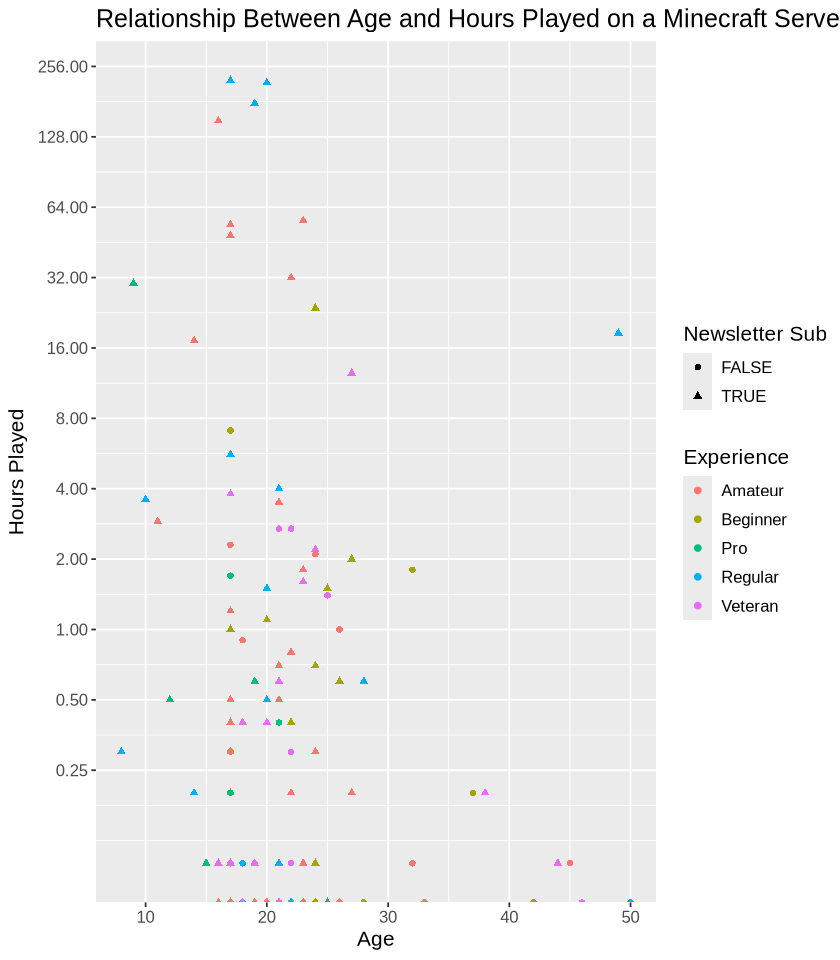

In [135]:
playing <- players |>
    mutate(age = Age) |>
    mutate(subscribe = as.factor(subscribe)) |>
    select(experience, subscribe, played_hours, age) |>
    na.omit()

options(repr.plot.width = 7, repr.plot.height = 8)
player_plot <- playing |>
    ggplot(aes(x = age, y = played_hours, color = experience, shape = subscribe)) +
    geom_point() +
    ggtitle("Relationship Between Age and Hours Played on a Minecraft Server") +
    labs(x = "Age", y = "Hours Played", color = "Experience", shape = "Newsletter Sub") +
    theme(text = element_text(size = 12.5)) +
    scale_y_continuous(trans = "log2", breaks = c(0.25,0.5,1,2,4,8,16,32,64,128,256))
    # scale_y_continuous(breaks = seq(0,224, by = 8))
player_plot